Welcome to Voxelmap!

The first thing we'll do is train the neural network (Network A). We'll then test the network to see how it performs.

hl


In [1]:
# imports
import time
import os
import numpy as np
from matplotlib import pyplot as plt
from utilities import network_a, losses
import torch
from torch.utils.data import Dataset
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")

# File Names

In [2]:
import os

Patient_number = "P2"
NoScatter = True
Scatter = False
DatasetType="SPARE"
DayofTreatment = 1
NetworkType="A"

if NoScatter == Scatter:
    raise ValueError("Set exactly one of NoScatter or Scatter to True.")

scatter_tag = "NS" if NoScatter else "SC"

im_dir = os.path.join(
    "/srv/shared/SPARE", # Will Change Based on Your Folder
    f"MC_V_{Patient_number}_{scatter_tag}_{DayofTreatment:02d}"
)

expt_description = f"Network_{NetworkType}_{DatasetType}_{Patient_number}"
filename = f"Train_Network_{NetworkType}_{DatasetType}_{Patient_number}"

print("im_dir =", im_dir)


im_dir = /srv/shared/SPARE/MC_V_P2_NS_01


# Setup Dataset

In [3]:
# set up training dataset class
class SupervisedDataset(Dataset):
    def __init__(self, im_dir=None, im_size=None):
        self.im_dir = im_dir
        self.im_size = im_size

    def __len__(self):
        return len([n for n in os.listdir(self.im_dir) if n.endswith('_bin.npy')])

    def __getitem__(self, idx):
        # Find target projection
        proj_list = sorted([n for n in os.listdir(self.im_dir) if n.endswith('_bin.npy')])
        target_file = proj_list[idx]
        proj_name = os.path.join(self.im_dir, format(target_file))
        target_proj = np.load(proj_name)
        target_proj = (target_proj - np.min(target_proj)) / (np.max(target_proj) - np.min(target_proj))

        # Find target DVF
        vol_num = target_file[:2]
        dvf_name = os.path.join(self.im_dir, format('DVF_' + vol_num + '_mha.npy'))
        target_dvf = np.load(dvf_name)

        # Find source projection
        source_file = '06_' + target_file[3:]
        proj_name = os.path.join(self.im_dir, format(source_file))
        source_proj = np.load(proj_name)
        source_proj = (source_proj - np.min(source_proj)) / (np.max(source_proj) - np.min(source_proj))

        # Find source volume
        vol_name = os.path.join(self.im_dir, format('subCT_06_mha.npy'))
        source_vol = np.load(vol_name)
        source_vol = (source_vol - np.min(source_vol)) / (np.max(source_vol) - np.min(source_vol))

        # Find source abdomen
        vol_name = os.path.join(self.im_dir, format('sub_Abdomen_mha.npy'))
        source_hull = np.load(vol_name)

        # Reshape data
        source_projections = np.zeros((1, self.im_size, self.im_size), dtype=np.float32)
        source_projections[0, :, :] = np.asarray(source_proj)
        target_projections = np.zeros((1, self.im_size, self.im_size), dtype=np.float32)
        target_projections[0, :, :] = np.asarray(target_proj)

        source_volumes = np.zeros((1, self.im_size, self.im_size, self.im_size), dtype=np.float32)
        source_volumes[0, :, :, :] = np.asarray(source_vol)
        source_abdomen = np.zeros((1, self.im_size, self.im_size, self.im_size), dtype=np.float32)
        source_abdomen[0, :, :, :] = np.asarray(source_hull)

        target_flow = np.zeros((3, self.im_size, self.im_size, self.im_size), dtype=np.float32)
        target_flow[0, :, :, :] = target_dvf[:, :, :, 0]
        target_flow[1, :, :, :] = target_dvf[:, :, :, 1]
        target_flow[2, :, :, :] = target_dvf[:, :, :, 2]

        data = {'source_projections': torch.from_numpy(source_projections),
                'target_projections': torch.from_numpy(target_projections),
                'source_volumes': torch.from_numpy(source_volumes),
                'source_abdomen': torch.from_numpy(source_abdomen),
                'target_flow': torch.from_numpy(target_flow)}

        return data

Lookin' good! Now we will create training and validation datasets

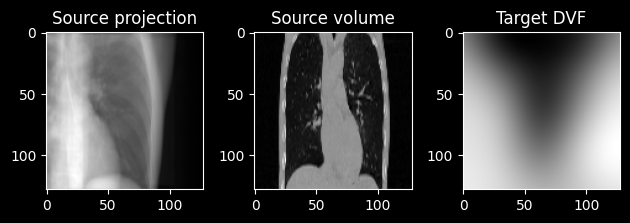

In [4]:
# Generate test loader
batch_size = 1
im_size = 128
exampleset = SupervisedDataset(im_dir=im_dir, im_size=im_size)
exampleloader = torch.utils.data.DataLoader(exampleset, batch_size=batch_size)
data = next(iter(exampleloader))

source_proj, target_proj, source_vol, source_abdomen, target_flow = data['source_projections'], \
                                                                                        data['target_projections'], \
                                                                                        data['source_volumes'], \
                                                                                        data['source_abdomen'], \
                                                                                        data['target_flow']
# visualise projection, volume and DVF
f = plt.figure()
plt.subplot(1,3,1)
source_proj = np.squeeze(source_proj)
plt.imshow(source_proj, cmap='gray')
plt.title('Source projection')

plt.subplot(1,3,2)
source_vol = np.squeeze(source_vol)
plt.imshow(np.transpose(source_vol[:,:, int(source_vol.shape[2] / 2)]), cmap='gray')
plt.title('Source volume')

plt.subplot(1,3,3)
target_flow = np.squeeze(target_flow)
plt.imshow(np.flipud(np.transpose(target_flow[1,:,:, int(source_vol.shape[2] / 2)])), cmap='gray')
plt.title('Target DVF')

f.tight_layout()
plt.show()

Network time! Let's set up a cuda implementation of the network, a loss function (good ol' MSE will do! but we're computing it within a thoracoabdominal mask) and an optimizer

In [5]:
import numpy as np

def get_numpy_similarity(path1, path2):
    # 1. Load the numpy arrays
    arr1 = np.load(path1)
    arr2 = np.load(path2)

    # 2. Flatten the arrays to 1D vectors
    # This works regardless of shape (e.g., 128x128x128 or 3x128x128x128)
    vec1 = arr1.flatten()
    vec2 = arr2.flatten()

    # 3. Calculate Dot Product
    dot_product = np.dot(vec1, vec2)

    # 4. Calculate Norms (Magnitudes)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)

    # 5. Compute Cosine Similarity
    # We add a tiny epsilon (1e-9) to avoid division by zero
    similarity = dot_product / (norm1 * norm2 + 1e-9)

    return similarity

# Usage
file_a = im_dir + "/06_Proj_00064_bin.npy"
file_b = "/srv/shared/SPARE/MC_V_P2_SC_02/"+ "source/06_Proj_00064_bin.npy"
score = get_numpy_similarity(file_a, file_b)
print(f"Cosine Similarity: {score:.6f}")

Cosine Similarity: 0.995928


It's important to note that , this difference is because there could have been changes to the anatomy between planning and treatment day.

Are you ready? Next thing to do is to train the network :) We'll save the weights and a plot of the loss curves. We recommend training for 50 epochs. (Using a NVIDIA RTX A6000, this will take 6-8 hours, so we may need to come back tomorrow.)

Let's instantiate the validation dataset class, set up a cuda implementation, and load the pre-trained weights of our network. We'll also print the number of trainable parameters for our records.

# Training

In [5]:
# generate train/test split
im_size = 128
batch_size = 8
dataset = SupervisedDataset(im_dir=im_dir, im_size=im_size)
split = [int(len(dataset) * 0.9), int(len(dataset) * 0.1)]
trainset, valset = torch.utils.data.dataset.random_split(dataset, split)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)

import continue_training
print(continue_training.__file__)
print(continue_training.plot_losses.__code__.co_varnames)

In [6]:
import continue_training
print(continue_training.__file__)
print(continue_training.plot_losses.__code__.co_varnames)

/home/saatwik/Desktop/voxelmap/Voxelmap-main/continue_training.py
('plot_dir', 'filename', 'expt_description', 'train_losses', 'val_losses', 'hours', 'minutes', 'DatasetType', 'NetworkType', 'Patient_number', 'plot_path', 'n', 'xs', 'hh')


In [ ]:

import os
import time
import numpy as np
import torch
import matplotlib.pyplot as plt

from continue_training import (
    save_checkpoint,
    load_checkpoint_if_available,
    plot_losses,
)

# ---- device (pick one and keep it consistent) ----
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# ---- set up network (EXACTLY as before) ----
model = network_a.model(im_size, int_steps=10).to(device)

# ---- loss + optimizer ----
flow_mask = losses.flow_mask()
lr = 1e-5
optimizer = optim.Adam(model.parameters(), lr=lr)

Training (on cuda:1)...
Starting at epoch 11 (target total: 70)
Epoch: 11 | train loss: 0.0626 | val loss: 0.0609 | total time: 0 hours 8 minutes
Epoch: 12 | train loss: 0.0628 | val loss: 0.0612 | total time: 0 hours 16 minutes
Epoch: 13 | train loss: 0.0629 | val loss: 0.0609 | total time: 0 hours 25 minutes
Epoch: 14 | train loss: 0.0630 | val loss: 0.0608 | total time: 0 hours 39 minutes
Epoch: 15 | train loss: 0.0625 | val loss: 0.0607 | total time: 0 hours 56 minutes
Epoch: 16 | train loss: 0.0630 | val loss: 0.0613 | total time: 1 hours 12 minutes
Epoch: 17 | train loss: 0.0633 | val loss: 0.0608 | total time: 1 hours 29 minutes
Epoch: 18 | train loss: 0.0627 | val loss: 0.0615 | total time: 1 hours 46 minutes
Epoch: 19 | train loss: 0.0626 | val loss: 0.0605 | total time: 2 hours 3 minutes
Epoch: 20 | train loss: 0.0622 | val loss: 0.0611 | total time: 2 hours 19 minutes
Epoch: 21 | train loss: 0.0630 | val loss: 0.0608 | total time: 2 hours 36 minutes
Epoch: 22 | train loss: 0

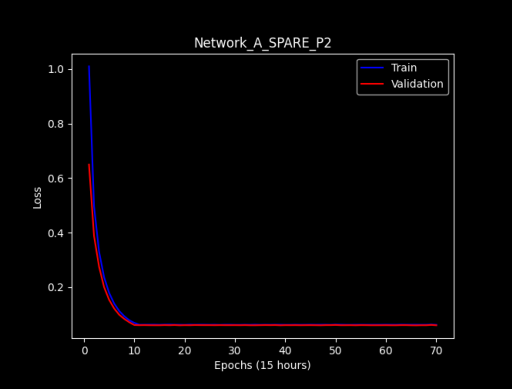

In [23]:
# =========================
# TRAIN (supports resume)
# =========================


print('Training (on ' + str(device) + ')...')
tic = time.time()

# IMPORTANT:
# epoch_num is the TOTAL epoch you want to reach.
# If you trained to 50 and want to continue to 100, set epoch_num = 100.
epoch_num = 70

save_dir = f"{DatasetType}_{NetworkType}_{Patient_number}_weights"
plot_dir = f"{DatasetType}_{NetworkType}_{Patient_number}_plots"
os.makedirs(save_dir, exist_ok=True)
os.makedirs(plot_dir, exist_ok=True)
# ---- resume (loads model+optimizer+history if checkpoint exists) ----
ckpt_path = os.path.join(save_dir, f"{DatasetType}_{NetworkType}_{Patient_number}_ckpt.pth")
start_epoch, min_val_loss, train_losses, val_losses = load_checkpoint_if_available(
    ckpt_path=ckpt_path,
    model=model,
    optimizer=optimizer,
    device=device,
)

print(f"Starting at epoch {start_epoch} (target total: {epoch_num})")

# ---- training loop ----
for epoch in range(start_epoch, epoch_num + 1):
    model.train()
    train_loss = 0.0

    for data in trainloader:
        source_proj = data['source_projections'].to(device)
        target_proj = data['target_projections'].to(device)
        source_vol = data['source_volumes'].to(device)
        source_abdomen = data['source_abdomen'].to(device)
        target_flow = data['target_flow'].to(device)

        optimizer.zero_grad(set_to_none=True)
        _, predict_flow = model.forward(source_proj, target_proj, source_vol)
        loss = flow_mask.loss(target_flow, predict_flow, source_abdomen)

        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for valdata in valloader:
            source_proj = valdata['source_projections'].to(device)
            target_proj = valdata['target_projections'].to(device)
            source_vol = valdata['source_volumes'].to(device)
            source_abdomen = valdata['source_abdomen'].to(device)
            target_flow = valdata['target_flow'].to(device)

            _, predict_flow = model.forward(source_proj, target_proj, source_vol)
            loss = flow_mask.loss(target_flow, predict_flow, source_abdomen)
            val_loss += loss.item()

    # ---- metrics ----
    toc = time.time()
    time_elapsed = (toc - tic) / 3600
    hours = int(np.floor(time_elapsed))
    minutes = int((time_elapsed - hours) * 60)

    train_avg = train_loss / len(trainloader)
    val_avg = val_loss / len(valloader)

    print('Epoch: %d | train loss: %.4f | val loss: %.4f | total time: %d hours %d minutes' %
          (epoch, train_avg, val_avg, hours, minutes))

    train_losses.append(train_avg)
    val_losses.append(val_avg)

    # ---- save best weights (inference) ----
    best_path = os.path.join(save_dir, f"{DatasetType}_{NetworkType}_{Patient_number}_best.pth")
    if val_avg < min_val_loss:
        min_val_loss = val_avg
        torch.save(model.state_dict(), best_path)

    # ---- save resume checkpoint (continue training) ----
    save_checkpoint(
        ckpt_path=ckpt_path,
        model=model,
        optimizer=optimizer,
        epoch=epoch,            # last completed epoch
        best_val=min_val_loss,
        train_losses=train_losses,
        val_losses=val_losses,
    )

    # ---- plot ----
    plot_losses(
        plot_dir=plot_dir,
        filename=filename,
        expt_description=expt_description,
        train_losses=train_losses,
        val_losses=val_losses,
        hours=hours,
        minutes=minutes,
        DatasetType=DatasetType,
        NetworkType=NetworkType,
        Patient_number=Patient_number
    )

print('Finished training')
torch.cuda.empty_cache()

# Show final plot
final_plot = os.path.join(plot_dir,f"{DatasetType}_{NetworkType}_{Patient_number}_TRAINvsVAL.png")
if os.path.exists(final_plot):
    plt.imshow(plt.imread(final_plot))
    plt.axis("off")
    plt.show()

# Testing

## Setting File Names

In [24]:
# file names
import os

Patient_number = "P2"
NoScatter = False
Scatter = True
DatasetType="SPARE"
DayofTreatment = 2
NetworkType="A"

if NoScatter == Scatter:
    raise ValueError("Set exactly one of NoScatter or Scatter to True.")

scatter_tag = "NS" if NoScatter else "SC"

im_dir = os.path.join(
    "/srv/shared/SPARE", # Will Change Based on Your Folder
    f"MC_V_{Patient_number}_{scatter_tag}_{DayofTreatment:02d}"
)


expt_file = f'{DatasetType}_{NetworkType}_{Patient_number}'
test_file =  os.path.join(
    "/srv/shared/SPARE", # Will Change Based on Your Folder
    f"MC_V_{Patient_number}_{scatter_tag}_{DayofTreatment:02d}"
) # We are using the treatment day dataset with scatter

Saved_folder="/home/saatwik/Desktop/voxelmap/Voxelmap-main/" # Change According to Your Folder
target_itv_ptv_dir = f"{Saved_folder}Target_ITVs_ALL_{DatasetType}_{NetworkType}_{Patient_number}"
print(test_file)
print(target_itv_ptv_dir)


/srv/shared/SPARE/MC_V_P2_SC_02
/home/saatwik/Desktop/voxelmap/Voxelmap-main/Target_ITVs_ALL_SPARE_A_P2


## Obtaining  Target PTV for All 680 Projections

In [25]:
import os
import numpy as np
import torch
from utilities import spatialTransform


def _ensure_src_ptv_5d(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x)
    if x.ndim == 3:
        x = x[None, None, ...]
    elif x.ndim == 5:
        pass
    else:
        raise ValueError(f"Unsupported source PTV shape {x.shape}")
    return x.astype(np.float32)


def _ensure_dvf_5d(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x)
    if x.ndim == 4 and x.shape[-1] == 3:
        x = np.transpose(x, (3, 0, 1, 2))[None, ...]
    elif x.ndim == 4 and x.shape[0] == 3:
        x = x[None, ...]
    elif x.ndim == 5 and x.shape[1] == 3:
        pass
    else:
        raise ValueError(f"Unsupported DVF shape {x.shape}")
    return x.astype(np.float32)

# source ptv changes wrt Patient
def generate_target_itv_ptv_10bins(
    im_dir: str,
    out_dir: str,
    im_size: int = 128,
    dvf_folder: str | None = None,
    #source_ptv_relpath: str = os.path.join("source", "itv_PTV_mha.npy"),
    source_ptv_relpath: str = os.path.join("sub_PTV_mha.npy"),
    dvf_pattern: str = "DVF_{:02d}_mha.npy",
    out_pattern: str = "Target_ITV_PTV_{:02d}_mha.npy",
):
    """
    Saves Target ITV PTVs into out_dir.
    """
    if dvf_folder is None:
        dvf_folder = im_dir

    os.makedirs(out_dir, exist_ok=True)

    src_ptv_path = os.path.join(im_dir, source_ptv_relpath)
    if not os.path.exists(src_ptv_path):
        raise FileNotFoundError(f"Missing source ITV PTV: {src_ptv_path}")

    source_ptv_np = _ensure_src_ptv_5d(np.load(src_ptv_path))
    if source_ptv_np.shape[-3:] != (im_size, im_size, im_size):
        raise ValueError(f"Source PTV spatial shape {source_ptv_np.shape[-3:]} != {(im_size,)*3}")

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    transformer = spatialTransform.Network([im_size, im_size, im_size]).to(device).eval()

    source_ptv_t = torch.from_numpy(source_ptv_np).to(device)

    for b in range(1, 11):
        dvf_path = os.path.join(dvf_folder, dvf_pattern.format(b))
        if not os.path.exists(dvf_path):
            raise FileNotFoundError(f"Missing DVF file: {dvf_path}")

        dvf_np = _ensure_dvf_5d(np.load(dvf_path))
        if dvf_np.shape[-3:] != (im_size, im_size, im_size):
            raise ValueError(f"DVF spatial shape mismatch for {dvf_path}")

        dvf_t = torch.from_numpy(dvf_np).to(device)

        with torch.no_grad():
            tgt_ptv_t = transformer(source_ptv_t, dvf_t)

        tgt_ptv_np = tgt_ptv_t.detach().cpu().numpy()  # [1,1,D,H,W]

        out_path = os.path.join(out_dir, out_pattern.format(b))
        np.save(out_path, tgt_ptv_np)
        print(f"Saved {out_path}")

    print("Done. Target ITV PTVs saved.")


# -------------------------
# Example usage
# -------------------------

# Save into MC_V_P1_SC_02/Target_ITV/
generate_target_itv_ptv_10bins(
    im_dir=test_file,
    out_dir=f"{Saved_folder}Target_ITV_{DatasetType}_{NetworkType}_{Patient_number}",
    im_size=128,
)


Saved /home/saatwik/Desktop/voxelmap/Voxelmap-main/Target_ITV_SPARE_A_P2/Target_ITV_PTV_01_mha.npy
Saved /home/saatwik/Desktop/voxelmap/Voxelmap-main/Target_ITV_SPARE_A_P2/Target_ITV_PTV_02_mha.npy
Saved /home/saatwik/Desktop/voxelmap/Voxelmap-main/Target_ITV_SPARE_A_P2/Target_ITV_PTV_03_mha.npy
Saved /home/saatwik/Desktop/voxelmap/Voxelmap-main/Target_ITV_SPARE_A_P2/Target_ITV_PTV_04_mha.npy
Saved /home/saatwik/Desktop/voxelmap/Voxelmap-main/Target_ITV_SPARE_A_P2/Target_ITV_PTV_05_mha.npy
Saved /home/saatwik/Desktop/voxelmap/Voxelmap-main/Target_ITV_SPARE_A_P2/Target_ITV_PTV_06_mha.npy
Saved /home/saatwik/Desktop/voxelmap/Voxelmap-main/Target_ITV_SPARE_A_P2/Target_ITV_PTV_07_mha.npy
Saved /home/saatwik/Desktop/voxelmap/Voxelmap-main/Target_ITV_SPARE_A_P2/Target_ITV_PTV_08_mha.npy
Saved /home/saatwik/Desktop/voxelmap/Voxelmap-main/Target_ITV_SPARE_A_P2/Target_ITV_PTV_09_mha.npy
Saved /home/saatwik/Desktop/voxelmap/Voxelmap-main/Target_ITV_SPARE_A_P2/Target_ITV_PTV_10_mha.npy
Done. Targ

In [12]:
import os
import shutil
import csv

# -----------------------------
# Paths
# -----------------------------
target_itv_dir = f"{Saved_folder}Target_ITV_{DatasetType}_{NetworkType}_{Patient_number}"
respbin_csv = f"{test_file}/RespBin.csv"
output_dir = f"{Saved_folder}Target_ITVs_ALL_{DatasetType}_{NetworkType}_{Patient_number}"

os.makedirs(output_dir, exist_ok=True)

targets_created = 0

# -----------------------------
# Read CSV and create ITVs
# -----------------------------
with open(respbin_csv, newline='') as csvfile:
    reader = csv.reader(csvfile)

    for target_idx, row in enumerate(reader, start=1):

        # Skip empty rows
        if not row:
            continue

        # Single column = breathing phase
        breathing_phase = int(row[0])
        if not (1 <= breathing_phase <= 10):
            raise ValueError(
                f"Invalid breathing phase {breathing_phase} at target {target_idx}"
            )

        phase_str = f"{breathing_phase:02d}"

        src_itv = os.path.join(
            target_itv_dir,
            f"Target_ITV_PTV_{phase_str}_mha.npy"
        )

        if not os.path.exists(src_itv):
            raise FileNotFoundError(f"Missing ITV file: {src_itv}")

        dst_itv = os.path.join(
            output_dir,
            f"Target_{target_idx:05d}_ITV_PTV.npy"
        )

        shutil.copy(src_itv, dst_itv)
        targets_created += 1

        if targets_created % 50 == 0:
            print(f"Processed {targets_created} targets...")

print(f"\n Successfully created {targets_created} Target ITV PTVs")
print(f" Output directory: {output_dir}")


Processed 50 targets...
Processed 100 targets...
Processed 150 targets...
Processed 200 targets...
Processed 250 targets...
Processed 300 targets...
Processed 350 targets...
Processed 400 targets...
Processed 450 targets...
Processed 500 targets...
Processed 550 targets...
Processed 600 targets...
Processed 650 targets...

 Successfully created 680 Target ITV PTVs
 Output directory: /home/saatwik/Desktop/voxelmap/Voxelmap-main/Target_ITVs_ALL_SPARE_A_P2


## Preparing testing Functions

In [26]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset

class validateSPAREDataset(Dataset):
    def __init__(self, im_dir=None, im_size=None):
        self.im_dir = im_dir
        # Source files (Phase 06) and global contours are in the 'source' subfolder Within the Treatment Day Dataset
        self.ref_dir = os.path.join(im_dir, 'source')
        self.im_size = im_size

    def __len__(self):
        # Count target projections (excluding phase 06 reference files)
        return len([n for n in os.listdir(self.im_dir) if n.endswith('_bin.npy') and not n.startswith('06_')])

    def __getitem__(self, idx):
        # 1. Find target projection
        proj_list = sorted([n for n in os.listdir(self.im_dir) if n.endswith('_bin.npy') and not n.startswith('06_')])
        target_file = proj_list[idx]
        target_proj = np.load(os.path.join(self.im_dir, target_file))

        # 2. Find target volume using RespBin.csv logic
        resp_bin_path = os.path.join(self.im_dir, 'RespBin.csv')
        resp_bins = np.genfromtxt(resp_bin_path)
        bin_val = int(resp_bins[idx])

        # Format the volume number (e.g., 1 -> '01', 10 -> '10')
        if bin_val < 10:
            vol_num = '0' + str(bin_val)
        else:
            vol_num = str(bin_val) # Assuming 10 is the max, else use str(bin_val)

        # Load the volume corresponding to the bin index
        target_vol = np.load(os.path.join(self.im_dir, f'subCT_{vol_num}_mha.npy'))

        # 3. Find source data (Reference Phase 06) from the 'source' folder
        # Reconstructs source filename (e.g., 01_Proj_001.npy -> 06_Proj_001.npy)
        source_proj_name = '06_'+"Proj_" + '_'.join(target_file.split('_')[1:])
        source_proj = np.load(os.path.join(self.ref_dir, source_proj_name))

        source_vol = np.load(os.path.join(self.im_dir, 'subCT_06_mha.npy'))

        # 4. Find restricted contours (Lung and PTV only) from 'source' folder
        #source_lung = np.load(os.path.join(self.ref_dir, 'itv_Lung_mha.npy'))
        #source_ptv = np.load(os.path.join(self.ref_dir, 'itv_PTV_mha.npy'))

        #Patient 2 uses sub_PTV instead of itv_PTV
        source_ptv = np.load(os.path.join(self.im_dir, 'sub_PTV_mha.npy'))


        # 5. Load Angle
        angle_data = np.genfromtxt(os.path.join(self.im_dir, 'Angles.csv'))
        angle = angle_data[idx]

        # Find target contours
        target_num = target_file.split('_')
        target_num = target_num[1]


        vol_name = os.path.join(target_itv_ptv_dir, format('Target_' + target_num + '_ITV_PTV.npy'))
        target_ptv = np.load(vol_name)

        # 6. Reshape and convert to Tensors
        def to_tensor(data, is_vol=True):
            if is_vol:
                out = np.zeros((1, self.im_size, self.im_size, self.im_size), dtype=np.float32)
                out[0, ...] = np.asarray(data)
            else:
                out = np.zeros((1, self.im_size, self.im_size), dtype=np.float32)
                out[0, ...] = np.asarray(data)
            return torch.from_numpy(out)

        data = {
            'source_projections': to_tensor(source_proj, is_vol=False),
            'target_projections': to_tensor(target_proj, is_vol=False),
            'source_volumes': to_tensor(source_vol),
            #'source_lung': to_tensor(source_lung), # If available use it
            'source_ptv': to_tensor(source_ptv),
            'target_volumes': to_tensor(target_vol),
            'angle': angle,
            'target_ptv' :to_tensor(target_ptv)
        }

        return data

## Initiating Testing

In [27]:
# Generate test loader
batch_size = 1
im_size = 128
#dataset = validateSPAREDataset(im_dir=test_file, ref_dir=test_file + '/source', im_size=im_size)
# The class now handles the '/source' path internally
dataset = validateSPAREDataset(im_dir=test_file, im_size=im_size)
testloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Import network and set up cuda implementation
#model = network_a.VxmDense(im_size, int_steps=10)
model = network_a.model(im_size, int_steps=10)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load weights
PATH = f'{DatasetType}_{NetworkType}_{Patient_number}_weights/' +f"{DatasetType}_{NetworkType}_{Patient_number}_best" + '.pth'
model.load_state_dict(torch.load(PATH, map_location=device))
model.eval()

print('Number of paramters: %d' % (sum(p.numel() for p in model.parameters() if p.requires_grad)))

Number of paramters: 10836973


In [28]:
# Load transformer
from utilities import spatialTransform
transformer = spatialTransform.Network([im_size, im_size, im_size])
transformer.to(device)

Network(
  (transformer): SpatialTransformer()
)

In [29]:
from utilities.helpers import centroid_shift_mm
centroid = losses.centroid_ptv()
dice = losses.dice()
jacobian_determinant = losses.jacobian_determinant()
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# Tracking metrics
tar_lr, tar_si, tar_ap = [], [], []
pred_lr, pred_si, pred_ap = [], [], []
test_angles = []

# Regularity / overlap
test_dice = []
test_detJ = []

# Image quality (template style)
test_mse, test_ssim, test_psnr = [], [], []

print("Testing...")

for i, data in enumerate(testloader, 0):

    # ----------------------------
    # Load inputs (same set as your dataset provides)
    # ----------------------------
    source_proj = data['source_projections'].to(device)
    target_proj = data['target_projections'].to(device)
    source_vol  = data['source_volumes'].to(device)
    target_vol  = data['target_volumes'].to(device)
    source_ptv  = data['source_ptv'].to(device)
    target_ptv  = data['target_ptv'].to(device)
    angle       = data['angle'].to(device)

    # ----------------------------
    # Predict DVF
    # ----------------------------
    _, pred_flow = model.forward(source_proj, target_proj, source_vol)

    # ----------------------------
    # Warp source PTV using predicted DVF
    # ----------------------------
    pred_ptv = transformer.forward(source_ptv, pred_flow)

    # ----------------------------
    # Predicted motion (centroid shift)
    # ----------------------------
    pred_lr_mm, pred_si_mm, pred_ap_mm = centroid_shift_mm(
        centroid, source_ptv, pred_ptv
    )

    pred_lr.append(pred_lr_mm)
    pred_si.append(pred_si_mm)
    pred_ap.append(pred_ap_mm)

    # ----------------------------
    # Ground-truth motion (GT DVF-warped PTV)
    # ----------------------------
    gt_lr_mm, gt_si_mm, gt_ap_mm = centroid_shift_mm(
        centroid, source_ptv, target_ptv
    )

    tar_lr.append(gt_lr_mm)
    tar_si.append(gt_si_mm)
    tar_ap.append(gt_ap_mm)

    # ----------------------------
    # Dice similarity (TEMPLATE)
    # ----------------------------
    dice_sim = dice.loss(target_ptv, pred_ptv)
    test_dice.append(float(dice_sim.item()))



    # ----------------------------
    # Jacobian violation ratio (TEMPLATE)
    # ----------------------------
    disp = np.zeros((im_size, im_size, im_size, 3), dtype=np.float32)
    metric_flows = np.squeeze(pred_flow.detach().cpu().numpy())  # (3, D, H, W)
    disp[:, :, :, 0] = metric_flows[0, :, :, :]
    disp[:, :, :, 1] = metric_flows[1, :, :, :]
    disp[:, :, :, 2] = metric_flows[2, :, :, :]

    detJ = jacobian_determinant.loss(disp)
    detJ_ratio = sum(j <= 0 for j in detJ.flatten()) / detJ.size
    test_detJ.append(float(detJ_ratio))

    # ----------------------------
    # Save gantry angle (TEMPLATE)
    # ----------------------------
    test_angles.append(float(angle.item()))

    # ----------------------------
    # Image Quality metrics (TEMPLATE: flatten + SSIM/PSNR on 1D vectors)
    # ----------------------------
    predict_vol = transformer.forward(source_vol, pred_flow)

    metric_input = target_vol.detach().cpu().numpy().flatten()
    metric_pred  = predict_vol.detach().cpu().numpy().flatten()

    mse_val  = np.sqrt(np.mean(np.square(metric_input - metric_pred)))
    ssim_val = ssim(metric_input, metric_pred,
                    data_range=(np.max(metric_pred) - np.min(metric_pred) + 1e-8))
    psnr_val = psnr(metric_input, metric_pred)

    test_mse.append(float(mse_val))
    test_ssim.append(float(ssim_val))
    test_psnr.append(float(psnr_val))

     # ----------------------------
    # Debug (first few)
    # ----------------------------
    if i < 5:
        print(f"[DBG idx={i}] angle={angle.item():.2f}")
        print("[DBG pred mm lr,si,ap]", pred_lr_mm, pred_si_mm, pred_ap_mm)
        print("[DBG gt   mm lr,si,ap]", gt_lr_mm,  gt_si_mm,  gt_ap_mm)


    if i % 10 == 0:
        print(f"{i} of {len(testloader)}")


Testing...
[DBG idx=0] angle=0.00
[DBG pred mm lr,si,ap] -1.5816783905029297 5.195757293701171 2.0283775329589844
[DBG gt   mm lr,si,ap] -1.8353824615478516 5.238921356201172 2.2446842193603516
0 of 680
[DBG idx=1] angle=0.53
[DBG pred mm lr,si,ap] -1.5799026489257812 5.229180908203125 2.0285377502441406
[DBG gt   mm lr,si,ap] -1.8353824615478516 5.238921356201172 2.2446842193603516
[DBG idx=2] angle=1.06
[DBG pred mm lr,si,ap] -1.587259292602539 5.451576995849609 1.9761333465576172
[DBG gt   mm lr,si,ap] 0.5060997009277344 3.9999908447265624 1.2902164459228516
[DBG idx=3] angle=1.59
[DBG pred mm lr,si,ap] -1.6000099182128906 5.49407958984375 1.9765739440917969
[DBG gt   mm lr,si,ap] 0.5060997009277344 3.9999908447265624 1.2902164459228516
[DBG idx=4] angle=2.12
[DBG pred mm lr,si,ap] -1.5930538177490234 5.466557312011719 1.9854259490966797
[DBG gt   mm lr,si,ap] 0.5060997009277344 3.9999908447265624 1.2902164459228516
10 of 680
20 of 680
30 of 680
40 of 680
50 of 680
60 of 680
70 of 6

## Saving Test Results

Metrics saved to: SPARE_A_P2_plots/SPARE_A_P2_Experiment


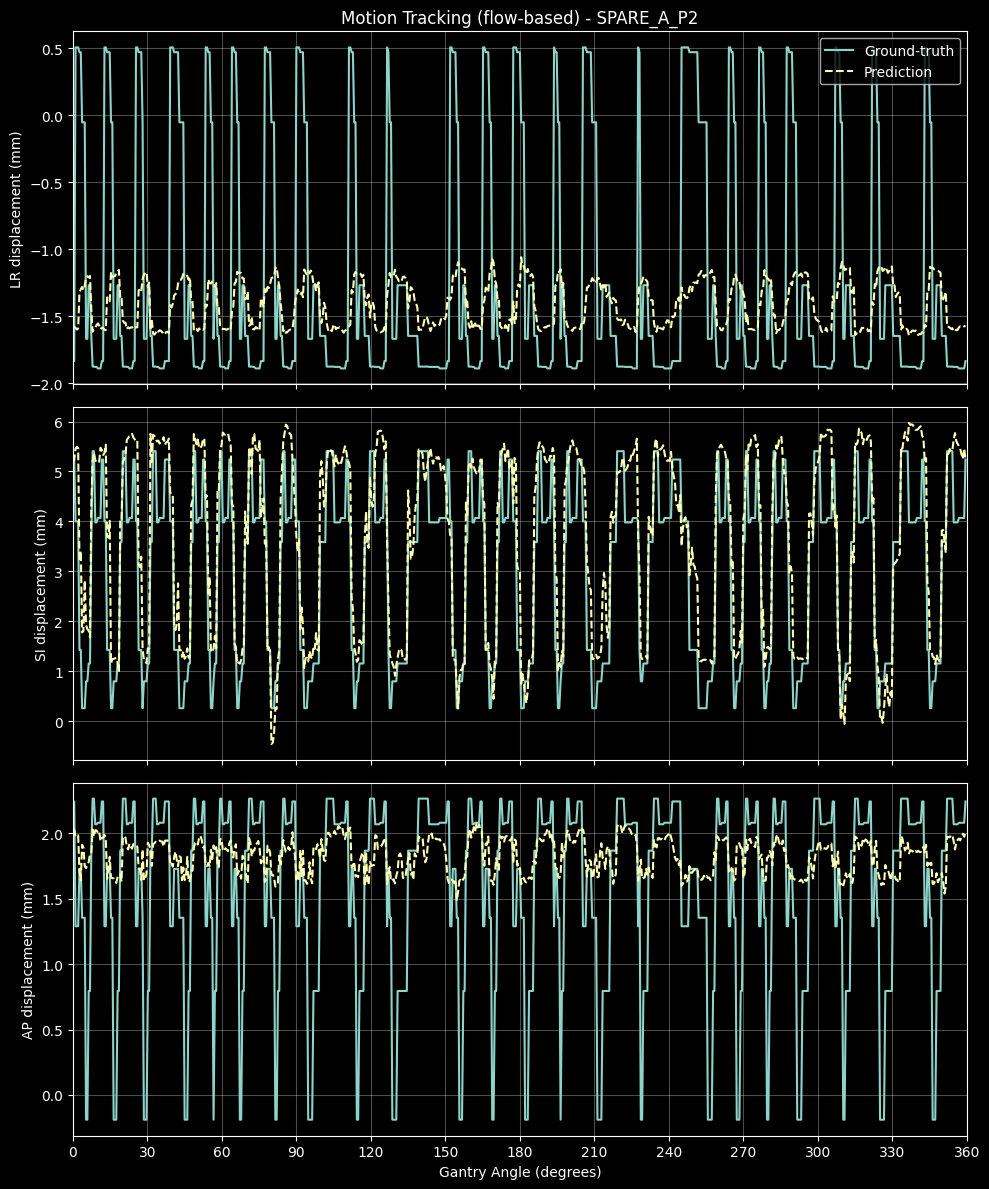

In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# OUTPUT DIR (use Code 2 pathing)
# -------------------------
# Assumes you already have:
#   plot_dir (base plots folder)
#   expt_file (experiment name)

out_dir = os.path.join(plot_dir, f"{expt_file}_Experiment")
os.makedirs(out_dir, exist_ok=True)

# Ensure everything is numpy before saving (from Code 2)
def as_numpy(x):
    if isinstance(x, np.ndarray):
        return x
    if isinstance(x, (list, tuple)):
        out = []
        for v in x:
            if hasattr(v, "detach"):  # torch tensor
                out.append(float(v.detach().cpu().item()) if v.numel() == 1 else v.detach().cpu().numpy())
            else:
                out.append(v)
        return np.asarray(out)
    if hasattr(x, "detach"):  # torch tensor
        return x.detach().cpu().numpy()
    return np.asarray(x)

# -------------------------
# SAVE ARRAYS (keep Code 1 variable names)
# -------------------------
np.save(os.path.join(out_dir, "test_angles.npy"), as_numpy(test_angles))
np.save(os.path.join(out_dir, "tar_lr_mm.npy"),   as_numpy(tar_lr))
np.save(os.path.join(out_dir, "tar_si_mm.npy"),   as_numpy(tar_si))
np.save(os.path.join(out_dir, "tar_ap_mm.npy"),   as_numpy(tar_ap))
np.save(os.path.join(out_dir, "pred_lr_mm.npy"),  as_numpy(pred_lr))
np.save(os.path.join(out_dir, "pred_si_mm.npy"),  as_numpy(pred_si))
np.save(os.path.join(out_dir, "pred_ap_mm.npy"),  as_numpy(pred_ap))

# Optional extras (if they exist in your run)
if "test_dice" in globals():
    np.save(os.path.join(out_dir, "test_dice.npy"), as_numpy(test_dice))
if "test_detJ" in globals():
    np.save(os.path.join(out_dir, "test_detJ.npy"), as_numpy(test_detJ))
if "test_mse" in globals():
    np.save(os.path.join(out_dir, "test_mse.npy"), as_numpy(test_mse))
if "test_ssim" in globals():
    np.save(os.path.join(out_dir, "test_ssim.npy"), as_numpy(test_ssim))
if "test_psnr" in globals():
    np.save(os.path.join(out_dir, "test_psnr.npy"), as_numpy(test_psnr))

print(f"Metrics saved to: {out_dir}")

# -------------------------
# PLOTTING (keep Code 1 logic)
# -------------------------

# Helper: sort a trace by angle (no mean-centering; these are displacements)
def sort_by_angle(trace, angles):
    trace = np.asarray(trace, dtype=float)
    angles = np.asarray(angles, dtype=float)
    order = np.argsort(angles)
    return angles[order], trace[order]

# Get sorted x-axis (angles) + traces
sorted_angles, tar_lr_plot  = sort_by_angle(tar_lr,  test_angles)
_,            tar_si_plot  = sort_by_angle(tar_si,  test_angles)
_,            tar_ap_plot  = sort_by_angle(tar_ap,  test_angles)

_,            pred_lr_plot = sort_by_angle(pred_lr, test_angles)
_,            pred_si_plot = sort_by_angle(pred_si, test_angles)
_,            pred_ap_plot = sort_by_angle(pred_ap, test_angles)

# Plotting
f, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

labels = ["LR displacement (mm)", "SI displacement (mm)", "AP displacement (mm)"]
tar_data  = [tar_lr_plot,  tar_si_plot,  tar_ap_plot]
pred_data = [pred_lr_plot, pred_si_plot, pred_ap_plot]

for idx, ax in enumerate(axes):
    ax.plot(sorted_angles, tar_data[idx],  label="Ground-truth")
    ax.plot(sorted_angles, pred_data[idx], label="Prediction", linestyle="--")
    ax.set_ylabel(labels[idx])

    ax.set_xlim([0, 360])
    ax.set_xticks(np.arange(0, 361, 30))
    ax.grid(True, alpha=0.3)

    if idx == 0:
        ax.set_title(f"Motion Tracking (flow-based) - {expt_file}")
        ax.legend(loc="upper right")

axes[-1].set_xlabel("Gantry Angle (degrees)")

f.tight_layout()
out_path = os.path.join(out_dir, f"{expt_file}_trace.png")
plt.savefig(out_path, dpi=200)
plt.show()
